# EDA on German Fake News Dataset

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk

#from nltk.corpus import stopwords
from dotenv import find_dotenv, load_dotenv
load_dotenv(find_dotenv())


pd.set_option('display.max_rows', 100)

## Read data

In [59]:

FAKE_NEWS_CSV = os.path.join(os.getenv('PROJECT_DIR'), 'data', 'interim', 'GermanFakeNC_interim.csv')
df = pd.read_csv(FAKE_NEWS_CSV)
df.head(20)

,Date,URL,False_Statement_1_Location,False_Statement_1_Index,False_Statement_2_Location,False_Statement_2_Index,False_Statement_3_Location,False_Statement_3_Index,Ratio_of_Fake_Statements,Overall_Rating,titel,text
0,2017-08-30,https://schluesselkindblog.com/2017/08/30/proz...,Text,213-237,NaN,NaN,NaN,NaN,1,0.7,NaN,NaN
1,2017-12-18,http://blauerbote.com/2017/12/18/bild-journali...,Text,13-36,Text,52-81,NaN,NaN,3,0.8,BILD-Journalist Julian Röpcke und seine Nazifr...,Es ist schon ein (Haken-) Kreuz mit der Bildze...
2,2017-06-02,http://blauerbote.com/2017/06/02/angela-merkel...,Title,1-7,Text,70-94,Text,121-153,3,0.7,Angela Merkel läßt Rock am Ring abbrechen – Bl...,Auch heute noch für Aufsehen sorgte der Widers...
3,2018-02-17,http://www.truth24.net/gruppenvergewaltigung-s...,Title,1-1,Title,3-4,Title,6-7,1,0.4,Gruppenvergewaltigung: Sex Jihadisten vergewal...,Bad Soden / Hofheim. Beim Herumvagabundieren ü...
4,2016-09-18,http://www.rapefugees.net/ozapft-is-tuerke-ver...,Text,18-37,NaN,NaN,NaN,NaN,1,0.5,Ozapft Is! Türke versucht Koreanerin auf die W...,Bereits der erste Tag startet wieder mit einer...
5,2018-02-09,https://blog.halle-leaks.de/dresden-wieder-kin...,Text,14-22,NaN,NaN,NaN,NaN,1,0.4,WARTUNGSARBEITEN,NaN
6,2018-02-05,https://www.unzensuriert.at/content/0026189-Ka...,Title,1-8,NaN,NaN,NaN,NaN,1,0.6,Katalonien: 100 Tage Diktatur des spanischen Z...,Spanien 5. Feber 2018 / 20:06\n\nKatalonien: 1...
7,2018-01-22,http://www.guidograndt.de/2018/01/22/kollegenb...,Text,31-56,Text,20-29,NaN,NaN,1,0.6,KOLLEGENBEITRAG: “Wähler-Verräter SPD?!”,EIN KOLLEGENBEITRAG von MICHAEL GRANDT\n\nSPD-...
8,2017-12-10,https://de.sott.net/article/31971-Umfrage-92-d...,Title,1-17,Text,157-187,Text,189-212,3,0.8,Schnauze voll von Poroschenko -- Das Kind der ...,Die meisten Zuschauer des ukrainischen TV-Send...
9,2018-02-17,http://info-direkt.eu/2018/02/17/staedte-volle...,Text,362-390,Text,441-459,Text,467-483,2,0.6,Städte voller leerer Menschen! Was tun?,"Der Mensch in einer Betonwüste, entwurzelt und..."


## Start exploring the data

In [9]:
print('Columns with missing values:')
print(df.isnull().sum())

Columns with missing values:
Date                           19
URL                             0
False_Statement_1_Location      0
False_Statement_1_Index        20
False_Statement_2_Location    125
False_Statement_2_Index       140
False_Statement_3_Location    231
False_Statement_3_Index       237
Ratio_of_Fake_Statements        0
Overall_Rating                  0
titel                          16
text                          103
dtype: int64


In [13]:
# Skip rows with NULL values in text and title
df_ = df.dropna(subset=['titel', 'text'])
df_.isnull().sum()

Date                           15
URL                             0
False_Statement_1_Location      0
False_Statement_1_Index        14
False_Statement_2_Location     77
False_Statement_2_Index        81
False_Statement_3_Location    144
False_Statement_3_Index       146
Ratio_of_Fake_Statements        0
Overall_Rating                  0
titel                           0
text                            0
dtype: int64

In [21]:
# Still NULLS for Date...
df_[df_['Date'].isnull()]

,Date,URL,False_Statement_1_Location,False_Statement_1_Index,False_Statement_2_Location,False_Statement_2_Index,False_Statement_3_Location,False_Statement_3_Index,Ratio_of_Fake_Statements,Overall_Rating,titel,text


From the URL we can see that the Date could be 2017/12 so we impute the Date to work with...

In [20]:
df_['Date'].fillna(pd.to_datetime('01/12/2017'), inplace=True)

/Users/dominikl/Python_Projekts/german_fake_news_classifier/envs/fake_news_env/lib/python3.8/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


First we check for duplicates in the dataset...

In [25]:
print(df_.duplicated(subset=['titel', 'text']).value_counts(normalize=True))
df_[df_.duplicated(subset=['titel', 'text'])]

False    1.0
dtype: float64


,index,Date,URL,False_Statement_1_Location,False_Statement_1_Index,False_Statement_2_Location,False_Statement_2_Index,False_Statement_3_Location,False_Statement_3_Index,Ratio_of_Fake_Statements,Overall_Rating,titel,text


In [24]:
# We drop them...
df_ = df_.drop_duplicates(subset=['titel', 'text']).reset_index()

Now lets have a quick look at how many words and characters we have in Titel and Body? 

In [28]:
# Count for max character and word length in Titel and Body
print('Max # of char in Title: %i' % df_['titel'].str.len().max())
cnt_lst = []
for i in range(0, len(df_)):
    cnt_lst.append(len(df_['titel'][i].split()))
print('Max # words in Title: %i' % max(cnt_lst))
print('Average # of words in Title: %i' % np.mean(cnt_lst))

print('Max char length of Body: %i' % df_['text'].str.len().max())
cnt_lst = []
for i in range(0, len(df_)):
    cnt_lst.append(len(df_['text'][i].split()))
print('Max # of words in Body: %i' % max(cnt_lst))
print('Average # of words in Body: %i' % np.mean(cnt_lst))

Max # of char in Title: 172
Max # words in Title: 25
Average # of words in Title: 11
Max char length of Body: 27973
Max # of words in Body: 4055
Average # of words in Body: 549


Ok, this seams to be quite reasonable for news articles.

### From what year they actually stem from?

<AxesSubplot:ylabel='Frequency'>

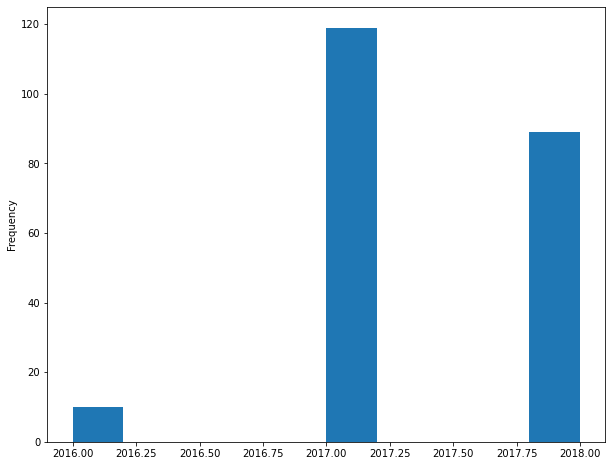

In [33]:
df_['Date'] = pd.to_datetime(df_['Date'])
df_['Year'] = df_['Date'].apply(lambda x: x.year)
df_['Year'].plot(kind = 'hist', figsize=(10, 8) )

Ok, so the majority of articles were published from 2017 to 2018. We are in 2021 as this EDA was perfromed. So the latest articles are already 3 years old. Could that have an implication on our model we want to train?
* Topics (and therefore the vocabulary) in the train data could be outdated? (e.g. Nobody talked about covid-19 in 2018!)

## Preprocessing and preparing text features

We already know (and expected) from a first look on the text features, that they contain a lot of stopwords. Therefore we take a stopword list from nltk.

Afterwards we ceate a word count matrix with CountVectorizer Object from scikit-learn and play around a bit...

In [49]:
# Init a stopword list from nltk and use it as arg in CountVectorizer...
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('german')
stemmer = nltk.stem.snowball.GermanStemmer(ignore_stopwords=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dominikl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

Count Vec Titel...

In [55]:
count_vec_titel = StemmedCountVectorizer(stop_words=stopword_list,
                                  token_pattern=r'\b[a-zA-Z]{2,}\b',
                                  max_features=50)
                                  #ngram_range=(2,2)
                                #)
# We first do that on Titel...
count_vec_titel.fit(df_['titel'])
word_counts_in_titel = count_vec_titel.transform(df_['titel']).todense()

### What are the most occuring words?

In [56]:
df_titel = pd.DataFrame(word_counts_in_titel, columns=count_vec_titel.get_feature_names())
df_titel_trans = pd.DataFrame(df_titel.T.sum(axis=1), columns=['count'])
df_titel_trans.sort_values(by='count', ascending=False).head(50)

,count
frau,20
wissenschaft,16
propaganda,15
sott,14
net,14
statt,14
vergewalt,13
zuerst,13
bot,13
blau,13


Now count vec the body...

In [57]:
count_vec_body = StemmedCountVectorizer(stop_words=stopword_list,
                                  token_pattern=r'\b[a-zA-Z]{2,}\b',
                                  max_features=50,
                                  #ngram_range=(2,2)
                                )
count_vec_body.fit(df_['text'])
word_counts_in_body = count_vec_body.transform(df_['text']).todense()

In [58]:
df_body = pd.DataFrame(word_counts_in_body, columns=count_vec_body.get_feature_names())
df_body_trans = pd.DataFrame(df_body.T.sum(axis=1), columns=['count'])
df_body_trans.sort_values(by='count', ascending=False).head(20)

,count
wurd,450
jahr,345
mehr,336
frau,311
deutsch,269
deutschland,262
polizei,260
kind,224
seit,218
polit,207
